# Minimum Variance Beamformer

参考论文：https://www.researchgate.net/publication/6135459_Adaptive_Beamforming_Applied_to_Medical_Ultrasound_Imaging

### 1. 生成钟组随机数据

##### (1) 基础仿真数据的生成

$ y(t)=[a + \epsilon{_1} * GN{_1}(\mu_1,\sigma_1)] + [b + \epsilon{_2} * GN{_2}(\mu_2,\sigma_2)] * t $

$ GN_{1} $ 代表钟在频率a上的噪声，$ GN_{2} $ 代表钟在频率漂移b上的噪声

$ a = μ_1 = μ_2 = 0, b = 10^{-15}, σ_1 = 2 × 10^{-30}, σ_2 = 10^{-34}, t = 1, 2, 3... $

In [19]:
a = 0
b = 10 ** (-15)
epsilon_1 = 1.0
epsilon_2 = 0.1
mu_1 = 0
mu_2 = 0
sigma_1 = 2 * 10 ** (-30)
sigma_2 = 10 ** (-34)

t = range(1,101) # 1,2,3...10
clock_size = 5

In [20]:
import math
import numpy as np
frequency = a + epsilon_1 * np.random.normal(loc=mu_1, scale=math.sqrt(sigma_1), size=(len(t), clock_size))
frequency_drift = b + epsilon_2 * np.random.normal(loc=mu_2, scale=math.sqrt(sigma_2), size=(len(t), clock_size))

In [21]:
y_t = frequency + np.array(t).reshape((-1,1)) * frequency_drift
print(y_t)

[[2.37413822e-15 1.06039149e-15 3.44050581e-15 1.44432605e-15
  8.95473562e-16]
 [2.30345000e-15 1.24418507e-15 3.05997476e-15 3.05671681e-15
  1.53330236e-15]
 [1.20459464e-15 1.68391072e-15 3.63392550e-15 3.91561275e-15
  1.73628466e-15]
 [4.46245460e-15 2.29120029e-15 5.72854255e-15 6.87347484e-15
  2.86655965e-15]
 [7.07295350e-15 3.69290287e-15 5.00339054e-15 7.52267949e-15
  3.61143641e-15]
 [6.36033368e-15 3.16945759e-15 8.24128761e-15 7.65912259e-15
  4.23131250e-15]
 [5.38013674e-15 7.03213334e-15 8.64888221e-15 7.33755195e-15
  5.46513962e-15]
 [7.35788748e-15 6.17134488e-15 9.18555136e-15 6.20270459e-15
  8.41853302e-15]
 [1.07344967e-14 7.76064003e-15 7.53445694e-15 9.47779043e-15
  7.57611174e-15]
 [7.46097592e-15 1.03262352e-14 1.25314637e-14 1.10984211e-14
  1.07257326e-14]
 [1.16012587e-14 1.15407184e-14 1.30562139e-14 1.07696718e-14
  1.24781949e-14]
 [1.10646153e-14 1.11343402e-14 1.22987611e-14 1.38494677e-14
  1.44030838e-14]
 [1.28394498e-14 1.41763738e-14 1.461947

##### (2) 添加相关性扰动

$ y_{i}(t) = y_{i}(t) + \beta GN_{s}, -1 < \beta < 1 $

$ GN_{s} $ 代表环境产生的噪声。β表示相关性的大小，用它来控制钟之间的相关性

In [22]:
beta_range = 1.0
beta_fix = False
mu_s = 0
sigma_s = 10 ** (-30)

if beta_fix:
    beta = beta_range * np.ones((1, clock_size))
else:
    beta = np.random.uniform(-beta_range, beta_range, clock_size)
noice_global = np.random.normal(loc=mu_s, scale=math.sqrt(sigma_s), size=(len(t), 1))

print(beta)
print(noice_global)

[-0.77851293 -0.42494966  0.92707929  0.98584183 -0.48506663]
[[-1.67354746e-16]
 [-1.55308738e-15]
 [ 2.52233895e-16]
 [ 7.21937064e-17]
 [ 1.99703104e-16]
 [ 4.28477255e-16]
 [-5.12702079e-16]
 [-2.07837030e-15]
 [ 6.02466463e-16]
 [-5.93304510e-16]
 [ 4.66944145e-16]
 [-9.96171312e-16]
 [ 9.15077957e-16]
 [ 2.59259986e-16]
 [ 1.15539967e-15]
 [ 7.70130438e-16]
 [-9.85962136e-16]
 [ 4.24942028e-16]
 [ 1.48329971e-15]
 [ 5.38696518e-16]
 [-1.82376885e-15]
 [ 8.54189975e-16]
 [ 1.50932384e-15]
 [-1.46989276e-15]
 [-8.78827926e-16]
 [-1.59872300e-15]
 [ 9.63191435e-16]
 [-7.63501418e-16]
 [-8.60756261e-17]
 [ 1.35023841e-15]
 [ 8.24372950e-17]
 [ 2.12154602e-18]
 [ 6.66533481e-16]
 [-7.05428801e-16]
 [-2.41349878e-16]
 [-3.33748402e-15]
 [ 1.19968446e-15]
 [ 1.28899124e-16]
 [ 3.39941903e-16]
 [ 6.34219089e-16]
 [ 1.27457774e-16]
 [ 3.84635998e-16]
 [ 7.98351797e-16]
 [ 3.72757334e-16]
 [-6.11120403e-16]
 [ 1.40585695e-15]
 [-2.32770125e-15]
 [-3.12312677e-16]
 [-1.90290396e-15]
 [-6.92

In [23]:
y_t = y_t + noice_global * beta
print(y_t)

[[2.50442605e-15 1.13150883e-15 3.28535469e-15 1.27934074e-15
  9.76651765e-16]
 [3.51254860e-15 1.90416902e-15 1.62013962e-15 1.52561832e-15
  2.28665322e-15]
 [1.00822729e-15 1.57672401e-15 3.86776632e-15 4.16427548e-15
  1.61393441e-15]
 [4.40625087e-15 2.26052160e-15 5.79547184e-15 6.94464641e-15
  2.83154089e-15]
 [6.91748205e-15 3.60803910e-15 5.18853115e-15 7.71955517e-15
  3.51456710e-15]
 [6.02675860e-15 2.98737632e-15 8.63852000e-15 8.08153339e-15
  4.02347248e-15]
 [5.77928194e-15 7.25000591e-15 8.17356673e-15 6.83210879e-15
  5.71383429e-15]
 [8.97592562e-15 7.05454764e-15 7.25873730e-15 4.15376023e-15
  9.42668109e-15]
 [1.02654688e-14 7.50462211e-15 8.09299112e-15 1.00717271e-14
  7.28387537e-15]
 [7.92287115e-15 1.05783597e-14 1.19814234e-14 1.05135167e-14
  1.10135248e-14]
 [1.12377367e-14 1.13422906e-14 1.34891081e-14 1.12300048e-14
  1.22516959e-14]
 [1.18401475e-14 1.15576629e-14 1.13752313e-14 1.28674004e-14
  1.48862933e-14]
 [1.21270498e-14 1.37875117e-14 1.546782

##### (3) 可视化各台钟的数据

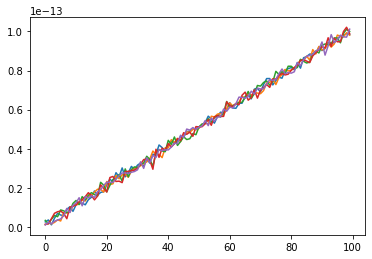

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(facecolor='white')
plt.plot(y_t)
plt.show()

### 2. 安装Allan Variance组件包

In [25]:
# https://allantools.readthedocs.io/en/latest/functions.html
!pip install allantools
import allantools

You should consider upgrading via the 'pip install --upgrade pip' command.


### 3. 生成子钟组

In [26]:
subset_size = 3
subsets = list()
if subset_size > y_t.shape[1]:
    raise Exception('The subset size should not be greater than the number of clocks')
for i in range(y_t.shape[1] - subset_size + 1):
    subset = y_t[:,i:i+subset_size]
    subsets.append(subset)
print(subsets)

[array([[2.50442605e-15, 1.13150883e-15, 3.28535469e-15],
       [3.51254860e-15, 1.90416902e-15, 1.62013962e-15],
       [1.00822729e-15, 1.57672401e-15, 3.86776632e-15],
       [4.40625087e-15, 2.26052160e-15, 5.79547184e-15],
       [6.91748205e-15, 3.60803910e-15, 5.18853115e-15],
       [6.02675860e-15, 2.98737632e-15, 8.63852000e-15],
       [5.77928194e-15, 7.25000591e-15, 8.17356673e-15],
       [8.97592562e-15, 7.05454764e-15, 7.25873730e-15],
       [1.02654688e-14, 7.50462211e-15, 8.09299112e-15],
       [7.92287115e-15, 1.05783597e-14, 1.19814234e-14],
       [1.12377367e-14, 1.13422906e-14, 1.34891081e-14],
       [1.18401475e-14, 1.15576629e-14, 1.13752313e-14],
       [1.21270498e-14, 1.37875117e-14, 1.54678248e-14],
       [1.12740501e-14, 1.32103146e-14, 1.37598599e-14],
       [1.38811413e-14, 1.58683802e-14, 1.61486483e-14],
       [1.51191594e-14, 1.60347290e-14, 1.74755540e-14],
       [1.83692350e-14, 1.78177469e-14, 1.65212981e-14],
       [1.61872465e-14, 1.9243

### 4. 在滑动窗口内计算协方差矩阵，并计算各子钟组权重

------------------Step 0------------------
*** Raw sum ***
[6.92128957e-15 7.03685724e-15 6.45271762e-15 1.24622443e-14
 1.57140523e-14 1.76526549e-14 2.12028546e-14 2.32892106e-14
 2.58630820e-14 3.04826543e-14 3.60691354e-14 3.47730418e-14
 4.13823863e-14 3.82442246e-14 4.58981699e-14 4.86294424e-14
 5.27082800e-14 5.12116421e-14 5.96152201e-14 5.70661518e-14]
*** Raw sum ***
[5.69620426e-15 5.04992696e-15 9.60876581e-15 1.50006399e-14
 1.65161254e-14 1.97074297e-14 2.22556814e-14 1.84670452e-14
 2.56693403e-14 3.30732998e-14 3.60614036e-14 3.58002946e-14
 4.32056454e-14 4.23926604e-14 4.94881656e-14 4.95597638e-14
 4.81396022e-14 5.07972068e-14 6.34871327e-14 5.87559783e-14]
*** Raw sum ***
[5.54134720e-15 5.43241115e-15 9.64597621e-15 1.55716591e-14
 1.64226534e-14 2.07435259e-14 2.07195098e-14 2.08391786e-14
 2.54485936e-14 3.35084649e-14 3.69708089e-14 3.91289250e-14
 4.01810749e-14 4.45424024e-14 4.84590764e-14 4.94178434e-14
 4.53541015e-14 4.95142610e-14 6.33511827e-14 6.22144

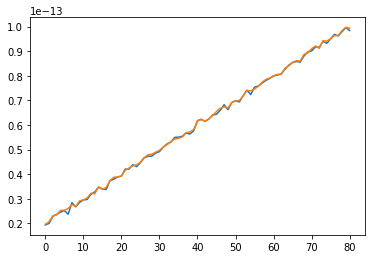

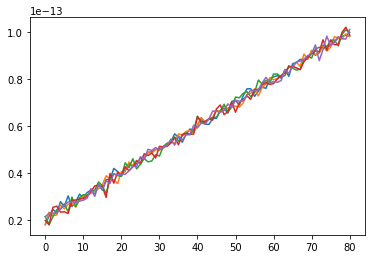

*** Weighted clock's Allan Variance ***
taus - [ 1.  2.  4.  8. 16.], adevs - [1.57534477e-15 8.45862007e-16 4.22226480e-16 2.27800611e-16
 1.89563653e-16]
*** Mean clock's Allan Variance ***
taus - [ 1.  2.  4.  8. 16.], adevs - [1.09847371e-15 6.78149257e-16 3.97631172e-16 1.80793922e-16
 9.95945323e-17]
*** Inverse variance weighted clock's Allan Variance ***
taus - [ 1.  2.  4.  8. 16.], adevs - [1.16630205e-15 6.50560951e-16 2.81260100e-16 1.65875100e-16
 5.69654473e-17]
*** Each clock's Allan Variance ***
taus - [ 1.  2.  4.  8. 16.], adevs - [2.73962562e-15 1.44937373e-15 7.96815311e-16 2.38613492e-16
 1.15056531e-16]
taus - [ 1.  2.  4.  8. 16.], adevs - [2.46166068e-15 1.13489597e-15 7.20997281e-16 4.02313766e-16
 2.16006747e-16]
taus - [ 1.  2.  4.  8. 16.], adevs - [3.03588812e-15 1.93199360e-15 7.89930367e-16 5.35317317e-16
 3.74295677e-16]
taus - [ 1.  2.  4.  8. 16.], adevs - [3.47709986e-15 1.65626787e-15 8.01089993e-16 7.09482156e-16
 3.39365178e-16]
taus - [ 1.  2.  4.

In [27]:
regularization = True
window_size = 20
window_step = 1
A = np.ones((clock_size - subset_size + 1, 1))

if window_size > y_t.shape[0]:
    raise Exception('The window size should not be greater than the number of time points')

    
weighted_clock_estimation = list()
weighted_inverse_variance_estimation = list()
for i in range(int((y_t.shape[0] - window_size) / window_step) + 1):
    subset_raw_sum_list = list()
    print("------------------Step %s------------------" % i)
    for j in range(len(subsets)):
        # 1. Get raw subset
        subset_raw = subsets[j][i:i+window_size,]
        
        # 2. Calculate summation within a subset 
        subset_raw_sum = np.sum(subset_raw, axis=1)
        subset_raw_sum_list.append(subset_raw_sum)
        print("*** Raw sum ***")
        print(subset_raw_sum)
   
    # 3. Calculate covariance matrix mean (Element-wise)
    print("*** Cov mean ***")
    allset_cov_mean = np.cov(np.asarray(subset_raw_sum_list)) / (clock_size - subset_size + 1)
    print(allset_cov_mean)
    print("*** Corr ***")
    allset_corr_mean = np.corrcoef(np.asarray(subset_raw_sum_list))
    print(allset_corr_mean)
    
    # 4. Add regularization term
    if regularization:
        print("*** Regularization term ***")
        sigma = np.max(allset_cov_mean) / (clock_size * 10.0)
        print(sigma * np.eye(clock_size - subset_size + 1))
        allset_cov_mean += sigma * np.eye(clock_size - subset_size + 1)
    
    
    # 5. Calculate the inverse of covariance matrix mean
    print("*** Inverse Cov mean ***")
    allset_cov_mean_inverse = np.linalg.inv(allset_cov_mean)
    print(allset_cov_mean_inverse)
    
    # 6. Calculate weight
    print("*** Weight ***")
    weight = np.dot(allset_cov_mean_inverse, A) / np.dot(np.dot(A.T, allset_cov_mean_inverse), A)
    print(weight)

    # 7. Calculate beamformer weighted clock
    print("*** Weighted output ***")
    Z = (np.dot(weight.T, np.asarray(subset_raw_sum_list)) / (clock_size - subset_size + 1))[0]
    print(Z)
    
    # 8. Select the last element in Z as the estimation of weighted clock
    weighted_clock_estimation.append(Z[-1])
    
    # 9. Calculate allan variance for each clock
    inverse_variance = list()
    clock_last_row = list()
    for k in range(clock_size):
        clock = y_t[window_step * i:window_step * i + window_size + 1, k]
        (taus, adevs, errors, ns) = allantools.adev(clock)
        inverse_variance.append(1.0 / adevs[0])
        clock_last_row.append(clock[-1])
    inverse_variance = np.array(inverse_variance) / np.sum(np.array(inverse_variance))
    print("*** Inverse variance weight ***")
    print(inverse_variance)
    
    # 10. Calculate the inverse variance weighted clock
    weighted_inverse_variance_clock = np.dot(inverse_variance, np.array(clock_last_row))
    print("*** Inverse variance weighted clock ***")
    print(weighted_inverse_variance_clock)
    weighted_inverse_variance_estimation.append(weighted_inverse_variance_clock)
    
# 11. Visualize weighted clock estimation and each clock
print("------------------Overall------------------")
print("*** Weighted clock estimation ***")
print(weighted_clock_estimation)

print("*** Inverse variance weighted clock estimation ***")
print(weighted_inverse_variance_estimation)

real_clock = y_t[-(int((y_t.shape[0] - window_size) / window_step) + 1):,]
real_clock_mean = np.mean(real_clock, axis=1)
print("*** Mean clock estimation ***")
print(real_clock_mean)

print("*** Clock covariance matrix ***")
print(np.cov(real_clock.T))

print("*** Clock corr matrix ***")
print(np.corrcoef(real_clock.T))

fig = plt.figure(facecolor='white')
plt.plot(weighted_clock_estimation)
plt.plot(real_clock_mean)
plt.show()

fig = plt.figure(facecolor='white')
plt.plot(real_clock)
plt.show()

# 12. Calculate Allan variance
print("*** Weighted clock's Allan Variance ***")
(taus, adevs, errors, ns) = allantools.adev(weighted_clock_estimation)
print('taus - %s, adevs - %s' % (taus, adevs))

print("*** Mean clock's Allan Variance ***")
(taus, adevs, errors, ns) = allantools.adev(real_clock_mean)
print('taus - %s, adevs - %s' % (taus, adevs))

print("*** Inverse variance weighted clock's Allan Variance ***")
(taus, adevs, errors, ns) = allantools.adev(weighted_inverse_variance_estimation)
print('taus - %s, adevs - %s' % (taus, adevs))

print("*** Each clock's Allan Variance ***")
for i in range(real_clock.shape[1]):
    (taus, adevs, errors, ns) = allantools.adev(real_clock[:,i])
    print('taus - %s, adevs - %s' % (taus, adevs))

### 计算R(n)的估计
$ \hat{R}(n)=\frac{1}{(2K+1)(M-L+1)}\sum_{k=-K}^K\sum_{l=0}^{M-L}\bar{X_l}(n-k)\bar{X_l}(n-k)^{H} $